In [1]:
from IPython.display import Image
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from scipy import optimize

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

# How many lines are there? 
(Sivia and Skilling, "Data Analysis : A Bayesian Tutorial", Chapter 4)

## Prelim

The parameters of the model are the following

\begin{align}
M   &: \textrm{Number of Line Peaks}\\
A_i &: \textrm{Amplitude of peak} \,i\\
x_i &: \textrm{Position of peak}\, i\\
D   &: \textrm{Experimental Data}
\end{align}

The prior information is summarized as

$I$: Lines peaks are measured as gaussians of fixed width $W$, subject to Gaussian noise of variance $\sigma$.

The inference problem to solve is then, given a spectra, how many peaks are there (at what positions and with what magnitudes)?



## Problem Definition
The posterior probability we are interested in is 

$\begin{align}
P(M D | I) &= P(M|DI)P(D|I) = P(D|MI)P(M|I) \\
P(M | D I) &= \frac{P(D|MI) P(M|I)}{P(D|I)} \\
P(M|I) &= \textrm{Prior for M}\\
P(D|I) &= \textrm{Prior for Data}\\
P(D|MI)&= \textrm{Likelihood}
\end{align}$

We can ignrome the priors, since they are just a normalizing constant, and the posterior becomes proportional to the evidence

$\begin{align}
P(M|D I) &\propto P(D|MI)
\end{align}$

Since the peak parameters $A_i$ and $x_i$ are independent of eachother, the nuisance parameters can be introduced and integrated over as follows

$\begin{align}
P(D|MI) &= \int \textrm{d}A^{M}\int\textrm{d}x^M P(D \{A_i, x_i\} | MI) \\
&= \int\textrm{d}A^{M}\int\textrm{d}x^M P(D|\{A_i,x_i\} M I) P(\{A_i,x_i\}|MI)
\end{align}$

Since the nuissance parameters are assumed mutually independent, we have

$\begin{align}
P(\{A_i,x_i\}|MI) &= \prod_{i} P(A_i,x_i|MI) \\
&= \prod_i P(A_i|MI) P(x_i|MI) \\
&= \left(A_{\text{max}} \left(x_{\text{max}} - x_{\text{min}}\right)\right)^{-M}
\end{align}$

where we assume flat probability distributions. Therefore, the posterior becomes

$\begin{align}
P(D|MI) &= \frac{1}{\left[A_{\text{max}} \left(x_\text{max} - x_\text{min}\right)\right]^M} \int\text{d}A^M\int\text{d}x^M P(D|\{A_i,x_i\} M I)
\end{align}$

Assume that the measurements $D_k$ are mutually independent and let $F_k$ denote the "real" values, in the absence of noise. Our prior information $I$ tells us that the measurements are subject ot Gaussian noise $\sigma_k$

$\begin{align}
P(D | \{A_i, x_i\} M I) &= P(\{D_k\} | \{A_i, x_i\} M I) = \prod_k P(D_k | \{A_i, x_i\}  M I) \\
&= \prod_k \frac{1}{\sigma_k \sqrt{2\pi}}e^{-\left(F_k - D_k\right)^2 / 2\sigma_k^2}\\
&\propto\exp\left(-\chi^2 / 2\right)\\
\chi^2 &= \sum_k\left(\frac{F_k - D_k}{\sigma_k}\right)^2
\end{align}$

where we can ignore the scaling factor proportional to $(\prod_k1/\sigma_k)$ since this is constant (i.e., the $\sigma_k$ are not model parameters).
Thus, we arrive at

$\begin{align}
P(D | MI) &\propto \frac{1}{\left[A_\text{max}\left(x_\text{max} - x_\text{min}\right)\right]^M} \int\text{d}A^M\int\text{d}x^M \exp{\left(-\chi^2/2\right)}
\end{align}$

We can continue analytically by expanding the integrand around the minimum of $\chi^2_{\text{min}}$ (at $X_0$), where $X = (A,x)$

$\begin{align}
\chi^2 \simeq \chi^2_\text{min} + \frac{1}{2}\left(X-X_0\right)^{\text{T}}\nabla\nabla\chi^2(X_0)\left(X - X_0\right) + \cdots
\end{align}$

$\begin{align}
P(D|MI) \propto \frac{1}{\left[A_\text{max}\left(x_\text{max} - x_\text{min}\right)\right]^M} e^{-\chi^2_\text{min}/2} \int\text{d}X^{2M} \exp{\bigg[ - \frac{1}{4}\left(X-X_0\right)^{\text{T}}\nabla\nabla \chi^2(X_0)\left(X - X_0\right)\bigg]}
\end{align}$

Thus, we just need to be able to evaluate an N-dimensional gaussian integral. 
If $H$ is a real symmetric (Hermitian) matrix, with positive eigen-values, then

$\begin{align}
G(X) &= \exp\bigg[-\frac{1}{2} X^\text{T} H X\bigg] \\
\iint\cdots\int G(X) \text{d}X^N &= \frac{(2\pi)^{N/2}}{\sqrt{\det{H}}}\\
\sigma^2 &= \langle(X_i - X_{0i})(X_j - X_{0j})\rangle = H^{-1}
\end{align}$

Therefore, the posterior probabilities can be approximated as

$\begin{align}
P(D | MI) &\propto \frac{M!}{\left[A_\text{max}(x_\text{max}-x_\text{min})\right]^M} \frac{(2\pi)^M}{\sqrt{\det{\left(\frac{1}{2} \nabla\nabla\chi(X_0)\right)}}} e^{-\chi^2_\text{min}/2}\\
&= \frac{M!}{\left[A_\text{max}(x_\text{max}-x_\text{min})\right]^M} \frac{(4\pi)^M}{\sqrt{\det{\left(\nabla\nabla\chi(X_0)\right)}}}e^{-\chi^2_\text{min}/2}
\end{align}$

where the factor of $M!$ is needed to take into account for the permutation of the different peaks (i.e., it shouldn't matter how we label them). Likewise, the errors are simply given as

$\begin{align}
\sigma^2 &= 2\left(\nabla\nabla\chi^2(X_0)\right)^{-1}
\end{align}$

For simplicity, we work instead with the logarithm of the probability

$\begin{align}
\log{P(M |DI)} &= -\frac{1}{2}\chi^2_\min + \log{M!} + M\big[\log{4\pi} - \log{A_{\text{max}}\left(x_\text{max} - x_\text{min}\right)}\big] - \frac{1}{2}\log{\big(\det{\nabla\nabla\chi(X_0)}\big)}
\end{align}$

The algorithm outlined by Sivia (Ch. 4.2.1), is the following:

- ($M=0$) : Assume that the backround is linear $B(x) = b_1 x + b_2$. Find the optimum values for this $2-d$ problem (b_1, b_2) that minimize $\chi^2$
- ($M=1$) : Find the best fit parameters for the one-line model. Overcome non-linearity problem by brute force, compute optimal parameters for range of $x_1$ values. Use this starting guess for full 4d optimization ($x_1, A_1, b_0, b_1$).
- ($M=2$) : Find the best fit for range of $x_2$ values, use this as guess for full optimization...
- Repeat

Additional Hints and Best Practices:
- Scale all parameters to be order unity and dimensionless
- Add small multiple of identity to the Hessian matrix : $\nabla\nabla \chi^2 \longrightarrow \nabla\nabla \chi^2 + \epsilon I$

In [2]:
def sample(gold, sig, num):
    """Compute noisy signal given optimum values"""
    def sample0(mu):
        draws = np.random.randn(num)*sig + mu
        return np.array([np.mean(draws), np.std(draws)])
    return np.array([sample0(mu) for mu in gold])

def signal0(x, fideal, fbackground, bb, bm, ai, xi):
    """Compute signal given background intercept, slope and series of amplitudes and peaks"""
    return np.sum(list(map(lambda a0,x0 : fideal(x, a0, x0), ai, xi)), axis=0) + fbackground(x, bb, bm)
    
def signal1(x, fideal, fbackground, params):
    """Compute signal given parameter list"""
    return signal0(x, fideal, fbackground, params[0], params[1], params[2::2], params[3::2])

def ideal(x, ai, xi):
    """Ideal signal"""
    return ai*np.exp(-(x - xi)**2/(2*0.01**2))

def back(x, bb, bm):
    """Background signal"""
    return bb + bm*x

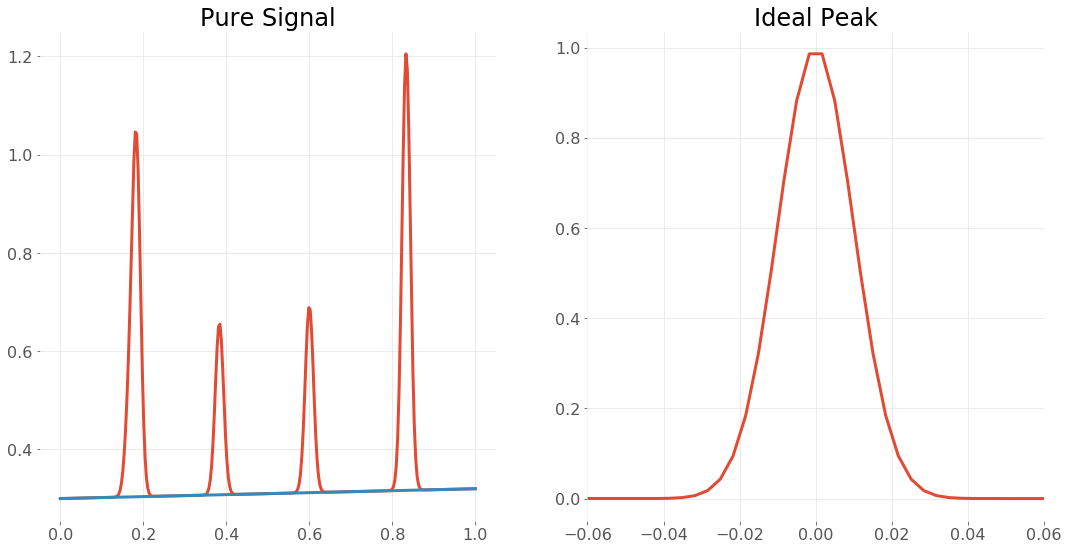

In [3]:
theta      = np.linspace(0, 1, num=300)
peaks      = {'pos':(np.array([11.5, 11.55, 12.15, 12.8, 13.5])-11.0)/3.0, 'amp':np.array([1.8, 7.0 ,3.5, 3.8, 8.9])/10} # normalized quantities
background = {'slope': 0.02, 'intercept':0.3}
gold       = signal0(theta, ideal, back, background['intercept'], background['slope'], peaks['amp'], peaks['pos'])

fig, [ax,bx] = plt.subplots(figsize=(18,9), ncols=2)
ax.plot(theta, gold)
ax.plot(theta, back(theta, background['intercept'], background['slope']))
bx.plot(theta-0.5, ideal(theta, 1, 0.5))
bx.set_xlim(-0.06, 0.06)
ax.set_title(r'Pure Signal')
bx.set_title(r'Ideal Peak');

In [4]:
# Now we generate some noisy data using different noise amplitudes
np.random.seed(12345)
sigmas= [0.02, 0.04, 0.06, 0.08, 0.10]
datas = [sample(gold, dmy, 50) for dmy in sigmas]
os.makedirs('./data', exist_ok=True)
for i,data in enumerate(datas):
    df = pd.DataFrame({'x':theta, 'y':data[:,0], 'dy':data[:,1]})
    df.to_csv(f'./data/exp_{i}.dat', sep=' ', index=False)

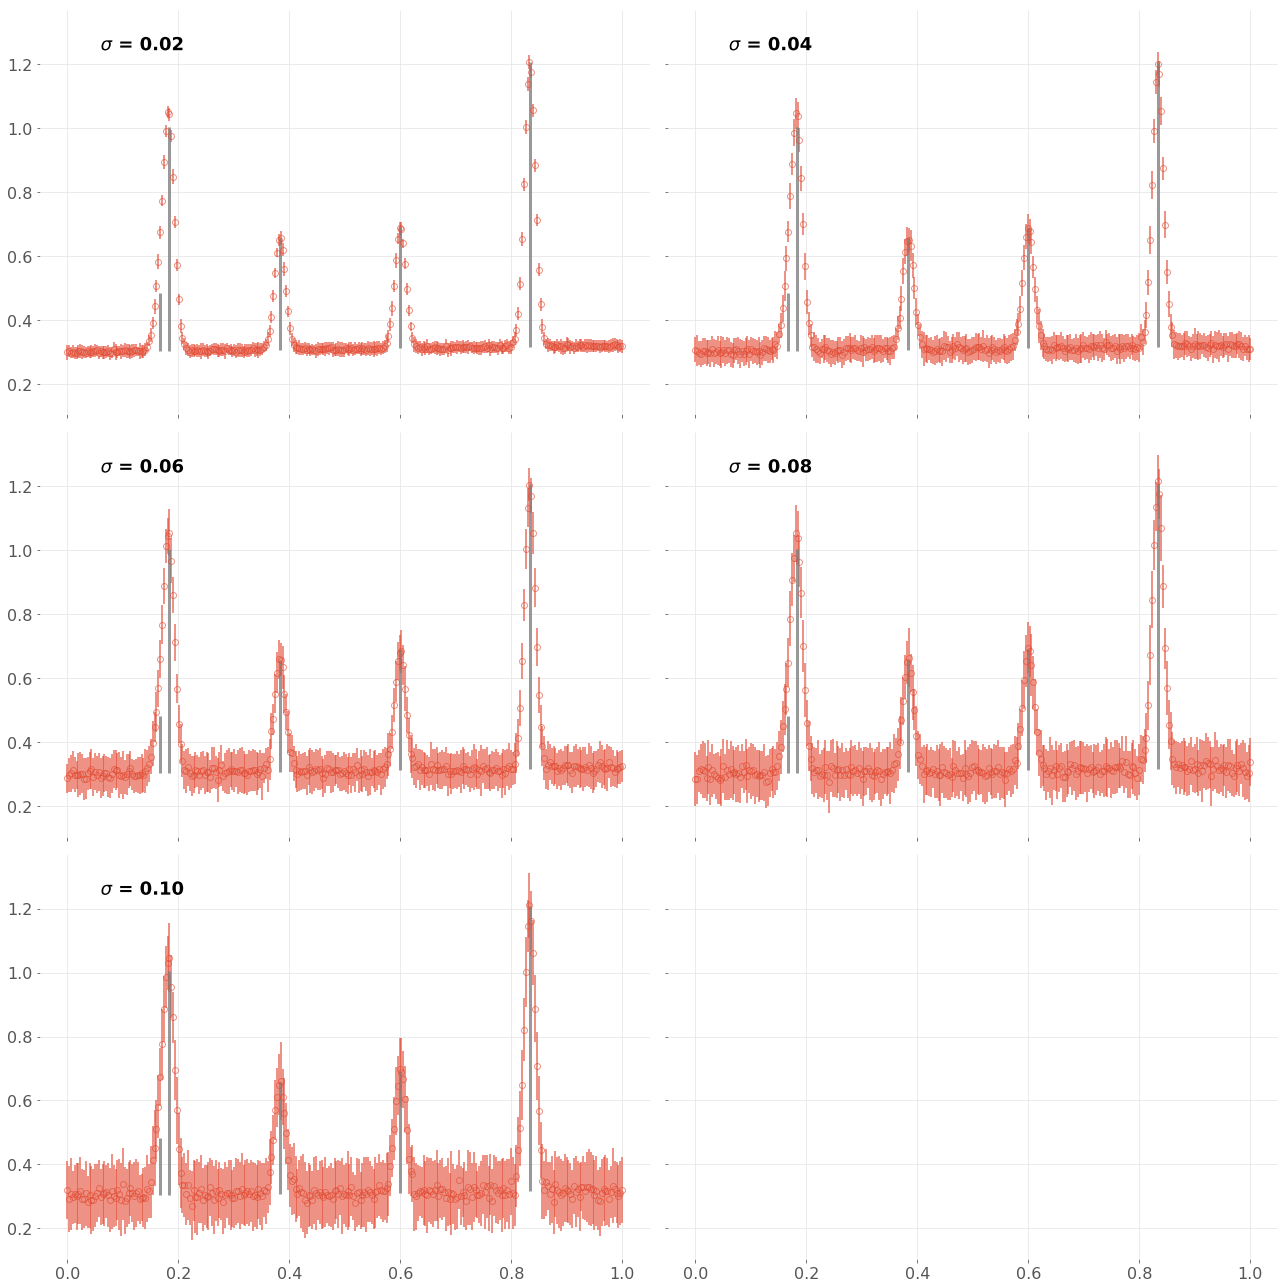

In [5]:
datas = [pd.read_csv(f'./data/exp_{i}.dat', sep=' ').to_numpy() for i in range(len(sigmas))]    

fig, axes = plt.subplots(figsize=(18,18), ncols=2, nrows=3, sharex=True, sharey=True)
for ax,data,s in zip(axes.flatten(), datas, sigmas):
    ax.errorbar(data[:,0], data[:,1], data[:,2], ls='None', lw=2, marker='o', ms=6, mfc='None', alpha=0.6)
#    ax.plot(theta, gold, alpha=0.8, lw=2)
    for x0,a0 in zip(peaks['pos'], peaks['amp']):
        baseline = background['intercept'] + background['slope']*x0
        ax.vlines(x0, baseline, baseline + a0, alpha=0.8, color='gray')
    addtxt(ax, 0.1, 0.9, f'$\sigma$ = {s:3.2f}', fs=18)
fig.tight_layout()
plt.show()

In [6]:
def chi2(yval, yerr, ygold):
    """Compute chi2 / N 
    Note: scaling by number of points N required for numerical stability
    """
    return np.mean(((yval - ygold)/yerr)**2)

def findPeaks(xval, yval, yerr, fideal, fbackground, Mmax, verbose):
    """Determine how peak positions in given signal
    xval        : measured x data
    yval        : measured y data
    yerr        : measured y uncertainty
    fideal      : function to compute ideal signal shape
    fbackground : function to compute ideal background shape
    verbose     : print detailed info?
    """

    def findAmp(peaks, init0):
        """Optimize background and amplitude parameters given position of the peaks
            peaks : fixed position of peaks
            init0 : initial guess for background + peak amplitudes
        """
        func0    = lambda p: chi2(yval, yerr, signal0(xval, fideal, fbackground, p[0], p[1], p[2:], peaks))
        return optimize.minimize(func0, init0, method='Nelder-Mead', options={'maxiter':200, 'disp':0})

    def findNextPeak(oldback, oldamps, oldpeaks):
        """Look for additional peak in data"""            
        #
        # 1D scan over x to locate candidate for next peak
        #
        init0       = np.zeros(2+len(oldamps)+1)
        init0[:2]   = oldback[:] 
        init0[2:-1] = oldamps[:]
        if len(oldamps) > 0:
            init0[-1]   = np.min(oldamps)*0.25
        else:
            init0[-1]   = np.min(yval)
            
        opt0        = [findAmp(np.append(oldpeaks, x0), init0) for x0 in xval] # scan x range and optimize amplitudes and background
        idx0        = np.argmin([dmy['fun'] for dmy in opt0])                  # find best guess for new peak (i.e., min chi2)
        param0      = opt0[idx0]['x']                                          # optimization parameters of best guess

        #
        # full optimization of 2M +2 parameter space
        # 
        M           = len(param0) - 2                                          # current number of peaks considered
        init1       = np.zeros(2*M + 2)                                        # initial guess
        init1[0:2]  = param0[0:2]                                              # background intercept + slope
        init1[2::2] = param0[2:]                                               # peak amplitudes
        init1[3::2] = np.append(oldpeaks, xval[idx0])                          # peak positions
        func        = lambda p : chi2(yval, yerr, signal1(xval, fideal, fbackground, p))
        opt1        = optimize.minimize(func, init1, method='Nelder-Mead', options={'maxiter':2000, 'disp':0}) # Simplex
        opt2        = optimize.minimize(func, opt1['x'], method='L-BFGS-B', options={'maxiter':1000, 'disp':0})
        opt3        = optimize.minimize(func, opt2['x'], method='BFGS', options={'maxiter':500, 'disp':0})
        opt2['hess_inv'] = (opt2['hess_inv'].todense())/len(xval)
        opt3['hess_inv'] = (opt3['hess_inv'])/len(xval)

        opts        = [opt1,opt2,opt3]
        for opt in opts:
            opt['chi2'] = opt['fun']*len(xval)
        for opt in opts[1:]:
            opt['hess'] = np.linalg.inv(opt['hess_inv'])
        return opts

    def fitBackground():
        func0   = lambda p : chi2(yval, yerr, signal0(xval, fideal, fbackground, p[0], p[1], [], []))
        init0   = np.array([np.min(yval), 0.0])
        opt0    = optimize.minimize(func0, [np.min(yval), 0.0], method='Nelder-Mead', options={'disp':0})
        return opt0['x']
    
    opts = []
    background, amps, peaks = fitBackground(), [], []
    print('*** Searching for Peaks ***')
    for M in range(Mmax):
        oo  = findNextPeak(background, amps, peaks)
        opts.append(oo)
        background = oo[-1]['x'][0:2]
        amps       = oo[-1]['x'][2::2]
        peaks      = oo[-1]['x'][3::2]
        if verbose:
            print(f'  M = {M+1}')
            for o in oo:
                print(f'   chi2 = {o["chi2"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    return opts

In [7]:
opts  = [findPeaks(data[:,0], data[:,1], data[:,2], ideal, back, 9, True) for data in datas]

*** Searching for Peaks ***
  M = 1
   chi2 = 1.142384e+04, niter =    71, Converged =      1 : Optimization terminated successfully.
   chi2 = 1.142384e+04, niter =     1, Converged =      1 : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
   chi2 = 1.142384e+04, niter =     7, Converged =      1 : Optimization terminated successfully.
  M = 2
   chi2 = 3.982123e+03, niter =    93, Converged =      1 : Optimization terminated successfully.
   chi2 = 3.982119e+03, niter =    12, Converged =      1 : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
   chi2 = 3.982119e+03, niter =     8, Converged =      1 : Optimization terminated successfully.
  M = 3
   chi2 = 1.960282e+03, niter =   124, Converged =      1 : Optimization terminated successfully.
   chi2 = 1.960277e+03, niter =    15, Converged =      1 : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
   chi2 = 1.960276e+03, niter =    11, Converged =      1 : Optimization terminated successfully.
  M = 4
   chi2 = 1.499581e

In [8]:
def logposterior(vol, opt):
    """Calculate posterior probability log(P(M|Data)) = -0.5 \chi^2_min + log(M!) + M[log(4\pi) - log(Amax(xmax - xmin))] - 0.5\log(\det{\nabla\nabla\chi})
        vol : prior volume term (Amax (xmax - xmin))^M
        pmin: minimization procedure
    """
    def logfact(n):
        """Calculate log(n!)"""
        return np.sum([np.log(i) for i in range(1,n+1)])
    hess    = opt['hess']
    M       = (len(opt['x'])-2)//2   
    alpha   = -opt['chi2']/2 + logfact(M) + M*np.log(4*np.pi/vol) - np.log(np.linalg.det(hess))/2
    return alpha

def normalize(logp): 
    """Compute normalized pdf"""
    normalization = reduce(np.logaddexp, logp)
    return logp - normalization

def estimates(opt):
    """Compute optimum position/amplitude and background"""
    xopt  = opt['x']
    ihess = opt['hess_inv']
    sig   = np.sqrt(2.0*np.diagonal(ihess))
    bb, bm, amp, pos = xopt[0], xopt[1], xopt[2::2], xopt[3::2]
    db, dm,damp,dpos = sig[0], sig[1], sig[2::2], sig[3::2]
    return [bb, db], [bm, dm], [pos, dpos], [amp, damp]

In [9]:
logps, bests = [], []
for opt, data in zip(opts, datas):
    x,y     = data[:,0], data[:,1]
    arange  = sp.integrate.simps(y, x=x)/sp.integrate.simps(signal0(x, ideal, back, np.min(y), 0.0, [0.5], [1.0]), x=x)
    xrange  = np.max(x) - np.min(x)
    logp    = normalize([logposterior(arange*xrange, om[-1]) for om in opt])
    bests.append(np.argmax(logp))
    logps.append(np.array([lp / np.log(10) for lp in logp]))

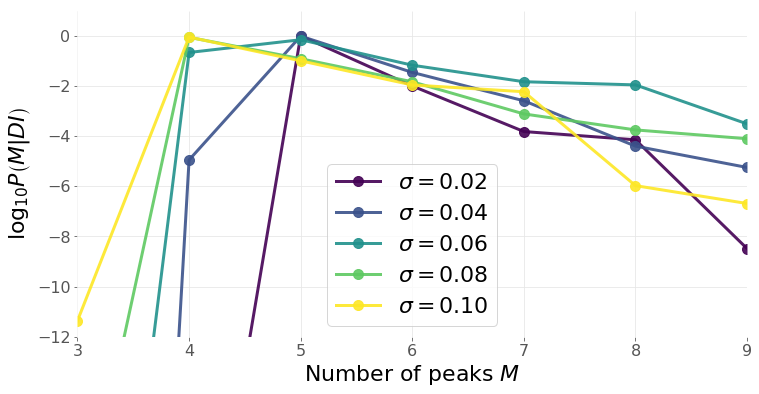

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
for lp,sig,c in zip(logps, sigmas, mpl.cm.viridis(np.linspace(0,1,len(sigmas)))):
    ax.plot(np.arange(1,10), lp, marker='o', color=c, label=f'$\sigma = {sig:.2f}$', alpha=0.9)
ax.set_xlim(3,9)
ax.set_ylim(-12,1)
ax.set_ylabel(r'$\log_{10}{P\left(M| D I\right)}$', fontsize=22)
ax.set_xlabel(r'Number of peaks $M$', fontsize=22)
ax.legend(fontsize=22)
plt.show()

Background parameters:
  m = 0.020 +/- 0.004, b = 0.300 +/- 0.002
  m = 0.019 +/- 0.008, b = 0.301 +/- 0.005
  m = 0.021 +/- 0.012, b = 0.299 +/- 0.007
  m = 0.012 +/- 0.017, b = 0.306 +/- 0.010
  m = 0.005 +/- 0.024, b = 0.309 +/- 0.014


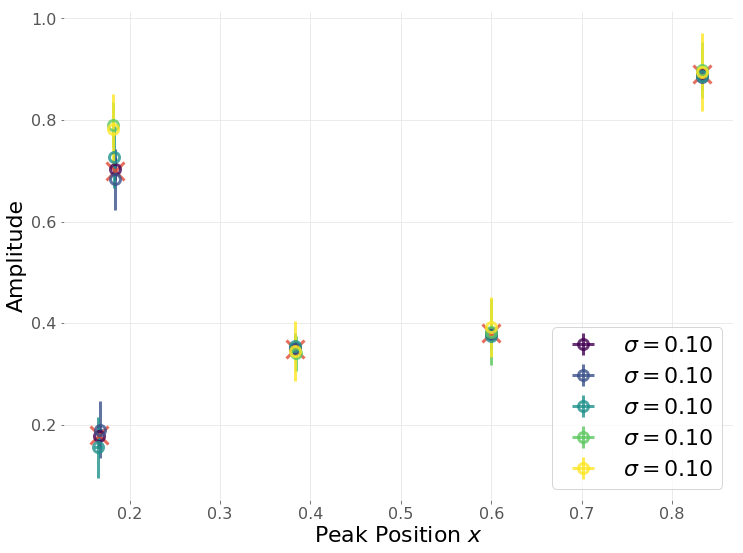

In [22]:
fig, ax = plt.subplots(figsize=(12,9))
#ax.vlines(peaks['pos'], 0.0, peaks['amp'], color='C3', alpha=0.5)
print(f'Background parameters:')
for best, opt, c in zip(bests, opts, mpl.cm.viridis(np.linspace(0, 1, len(sigmas)))):
    best_inter, best_slope, best_pos, best_amp = estimates(opt[best][-1])
    print(f'  m = {best_slope[0]:.3f} +/- {best_slope[1]:.3f}, b = {best_inter[0]:.3f} +/- {best_inter[1]:.3f}')
    ax.errorbar(best_pos[0], best_amp[0], xerr=best_pos[1], yerr=best_amp[1], \
                ls='none', marker='o', color=c, mew=3, mfc='None', alpha=0.8, label=f'$\sigma = {sig:.2f}$')
ax.plot(peaks['pos'], peaks['amp'], marker='x', ms=18, mew=3, ls='None', alpha=0.8, color='C0')
ax.legend(fontsize=22)
ax.set_xlabel(r'Peak Position $x$', fontsize=22)
ax.set_ylabel(r'Amplitude', fontsize=22)
plt.show()